In [1]:
# hello world
import numpy, pandas, xarray
print("NumPy:", numpy.__version__)
print("Pandas:", pandas.__version__)
print("Xarray:", xarray.__version__)

NumPy: 2.3.3
Pandas: 2.3.3
Xarray: 2025.4.0


In [2]:
import xarray as xr
import regionmask
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs# For map plotting
#1) Load the data with Dask
file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/totprecip.nc'
# Use Dask to load the dataset with chunking
ds = xr.open_dataset(file_path)
ds = ds.rename({'valid_time': 'time'})

# 2) Inspect the dataset
print(ds)

<xarray.Dataset> Size: 53MB
Dimensions:    (time: 909, latitude: 121, longitude: 121)
Coordinates:
    number     int64 8B ...
  * time       (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2025-09-01
  * latitude   (latitude) float64 968B 61.0 60.9 60.8 60.7 ... 49.2 49.1 49.0
  * longitude  (longitude) float64 968B -10.0 -9.9 -9.8 -9.7 ... 1.7 1.8 1.9 2.0
    expver     (time) <U4 15kB ...
Data variables:
    tp         (time, latitude, longitude) float32 53MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-20T17:31 GRIB to CDM+CF via cfgrib-0.9.1...


In [3]:
print(ds.longitude.values[:150])

[-1.00000000e+01 -9.90000000e+00 -9.80000000e+00 -9.70000000e+00
 -9.60000000e+00 -9.50000000e+00 -9.40000000e+00 -9.30000000e+00
 -9.20000000e+00 -9.10000000e+00 -9.00000000e+00 -8.90000000e+00
 -8.80000000e+00 -8.70000000e+00 -8.60000000e+00 -8.50000000e+00
 -8.40000000e+00 -8.30000000e+00 -8.20000000e+00 -8.10000000e+00
 -8.00000000e+00 -7.90000000e+00 -7.80000000e+00 -7.70000000e+00
 -7.60000000e+00 -7.50000000e+00 -7.40000000e+00 -7.30000000e+00
 -7.20000000e+00 -7.10000000e+00 -7.00000000e+00 -6.90000000e+00
 -6.80000000e+00 -6.70000000e+00 -6.60000000e+00 -6.50000000e+00
 -6.40000000e+00 -6.30000000e+00 -6.20000000e+00 -6.10000000e+00
 -6.00000000e+00 -5.90000000e+00 -5.80000000e+00 -5.70000000e+00
 -5.60000000e+00 -5.50000000e+00 -5.40000000e+00 -5.30000000e+00
 -5.20000000e+00 -5.10000000e+00 -5.00000000e+00 -4.90000000e+00
 -4.80000000e+00 -4.70000000e+00 -4.60000000e+00 -4.50000000e+00
 -4.40000000e+00 -4.30000000e+00 -4.20000000e+00 -4.10000000e+00
 -4.00000000e+00 -3.90000

Found United Kingdom in regionmask (index = 143)
Applied UK regionmask to variable 'tp'
909


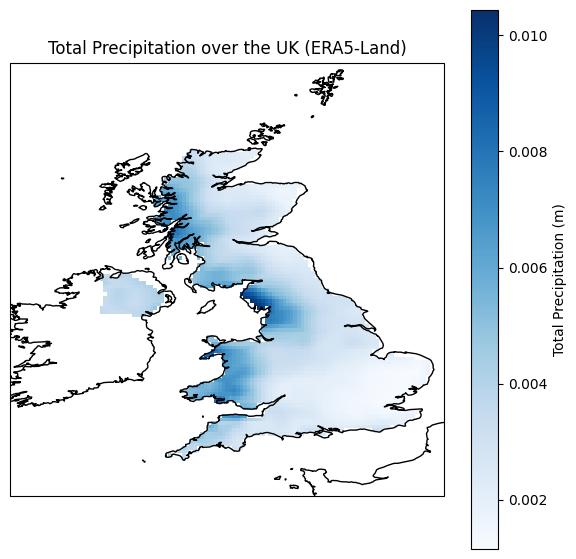

In [4]:
varname = 'tp'

# --- 3) Subset roughly to UK bounding box (optional, speeds up masking) ---
ds = ds.sel(latitude=slice(61, 49), longitude=slice(-10, 2))

# --- 4) Define regionmask for UK using Natural Earth polygons ---
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
uk_index = countries.names.index('United Kingdom')
print(f"Found United Kingdom in regionmask (index = {uk_index})")

# --- 5) Create and apply mask ---
mask = countries.mask(lon_or_obj=ds.longitude, lat=ds.latitude)

#mask = countries.mask(ds)
uk_data = ds[varname].where(mask == uk_index)
print(f"Applied UK regionmask to variable '{varname}'")
print(len(uk_data.time))

# --- 6) Plot the first timestep of the masked data ---
plt.figure(figsize=(7, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
uk_data.isel(time=908).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='Blues',
    cbar_kwargs={'label': 'Total Precipitation (m)'}
)
ax.coastlines()
plt.title(f"Total Precipitation over the UK (ERA5-Land)")
plt.show()



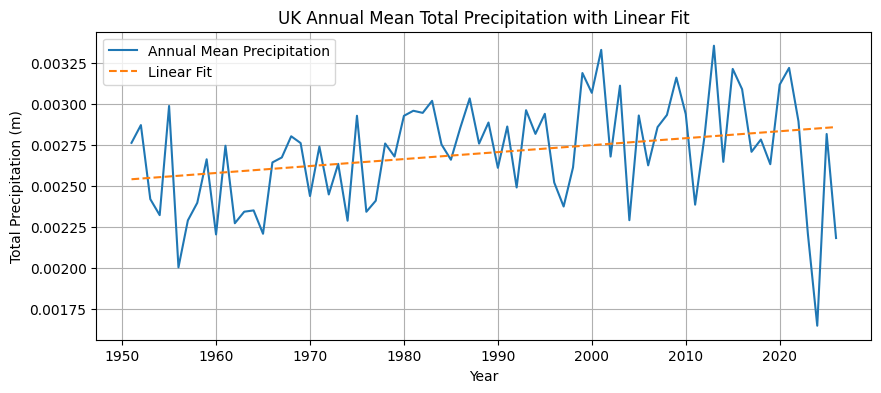

In [19]:

uk_annual = uk_data.mean(dim=['latitude','longitude'], skipna=True).resample(time='YE').mean()

# --- Linear fit ---
import numpy as np

y = uk_annual.values
x = np.arange(len(y))  # 0,1,2,... years
coeffs = np.polyfit(x, y, 1)  # linear fit
fit = np.polyval(coeffs, x)

# --- Plot ---
plt.figure(figsize=(10,4))
plt.plot(uk_annual['time'], y, label='Annual Mean Precipitation')
plt.plot(uk_annual['time'], fit, '--', label=f'Linear Fit')
plt.xlabel('Year')
plt.ylabel('Total Precipitation (m)')
plt.title('UK Annual Mean Total Precipitation with Linear Fit')
plt.legend()
plt.grid(True)
plt.show()


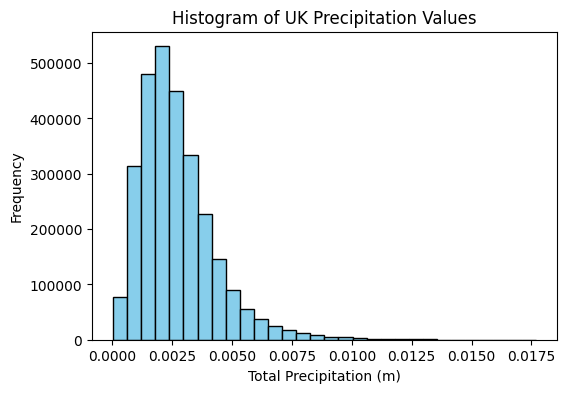

In [20]:
# Flatten all values into 1D array, ignoring NaNs
data_flat = uk_data.values.flatten()
data_flat = data_flat[~np.isnan(data_flat)]

plt.figure(figsize=(6,4))
plt.hist(data_flat, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Total Precipitation (m)')
plt.ylabel('Frequency')
plt.title('Histogram of UK Precipitation Values')
plt.show()


In [22]:
print(ds.tp)

<xarray.DataArray 'tp' (time: 909, latitude: 121, longitude: 121)> Size: 53MB
[13308669 values with dtype=float32]
Coordinates:
    number     int64 8B 0
  * time       (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2025-09-01
  * latitude   (latitude) float64 968B 61.0 60.9 60.8 60.7 ... 49.2 49.1 49.0
  * longitude  (longitude) float64 968B -10.0 -9.9 -9.8 -9.7 ... 1.7 1.8 1.9 2.0
    expver     (time) <U4 15kB ...
Attributes: (12/31)
    GRIB_paramId:                             228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      14641
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_gridType:                            regular_ll
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               m
    long_name:                                Total precipitation
    units:                      

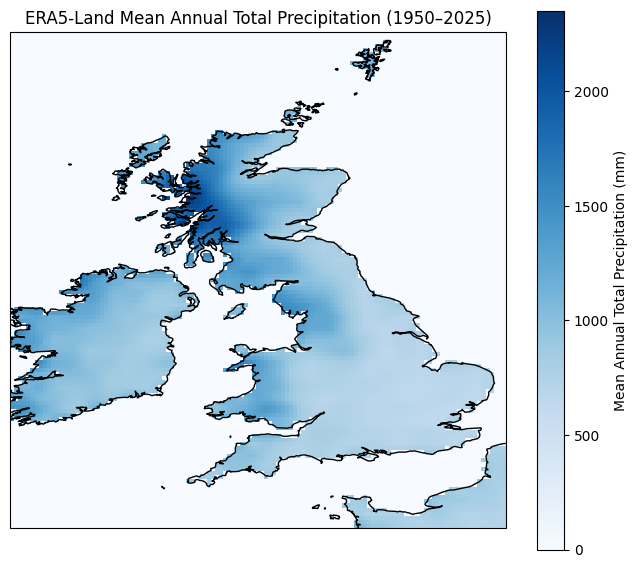

In [91]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# --- 1. Load the dataset ---
file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/totprecip.nc'
ds = xr.open_dataset(file_path)
ds = ds.rename({'valid_time': 'time'})

tp = ds['tp']  # total precipitation (m/day)

# --- 2. Compute number of days in each month ---
# make a DataArray aligned with tp.time
days_in_month = xr.DataArray(
    [pd.Timestamp(t.values).days_in_month for t in tp['time']],
    coords=[tp['time']],
    dims=['time']
)

# --- 3. Multiply each monthly mean by number of days to get monthly total (m/month) ---
tp_monthly_total = tp * days_in_month

# --- 4. Sum 12 months to get yearly totals ---
tp_yearly_total = tp_monthly_total.resample(time='YE').sum()

# --- 5. Compute mean annual total over all years (1950–2025) ---
tp_climatology = tp_yearly_total.mean(dim='time') * 1000  # convert m → mm

# --- 6. Plot ---
plt.figure(figsize=(8, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
tp_climatology.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='Blues',
    cbar_kwargs={'label': 'Mean Annual Total Precipitation (mm)'}
)
ax.coastlines()
ax.set_title('ERA5-Land Mean Annual Total Precipitation (1950–2025)')
plt.show()

In [64]:
# Select January 2025 and nearest Heathrow grid cell
tp = ds['tp']
tp_jan2025 = tp.sel(
    time='2025-01-01',
    longitude=-0.452,
    latitude=51.479,
    method='nearest'
)
print("Raw ERA5-Land value (m):", float(tp_jan2025.values))

tp_may2020 = tp.sel(
    time='2020-05-01',
    longitude=-0.452,
    latitude=51.479,
    method='nearest'
)
print("Raw ERA5-Land value (m):", float(tp_may2020.values))

tp_may2024 = tp.sel(
    time='2024-05-01',
    longitude=-0.452,
    latitude=51.479,
    method='nearest'
)
print("Raw ERA5-Land value (m):", float(tp_may2024.values))

tp_nov2019 = tp.sel(
    time='2019-11-01',
    longitude=-0.452,
    latitude=51.479,
    method='nearest'
)
print("Raw ERA5-Land value (m):", float(tp_nov2019.values))


Raw ERA5-Land value (m): 0.0025489781983196735
Raw ERA5-Land value (m): 0.0001331416715402156
Raw ERA5-Land value (m): 0.002616112818941474
Raw ERA5-Land value (m): 0.003058304311707616


In [63]:
tp_mm_days = float(tp_jan2025.values) * 31 * 1000
tp_mm = float(tp_may2020.values) * 31 * 1000
tp1_mm = float(tp_may2024.values) * 31 * 1000
tp2_mm = float(tp_nov2019.values) * 30 * 1000

print(f"ERA5-Land value (January 2025, Heathrow): {tp_mm_days:.3f} mm")
print(f"ERA5-Land value (May 2020, Heathrow): {tp_mm:.3f} mm")
print(f"ERA5-Land value (May 2024, Heathrow): {tp1_mm:.3f} mm")
print(f"ERA5-Land value (November 2019, Heathrow): {tp2_mm:.3f} mm")

ERA5-Land value (January 2025, Heathrow): 79.018 mm
ERA5-Land value (May 2020, Heathrow): 4.127 mm
ERA5-Land value (May 2024, Heathrow): 81.099 mm
ERA5-Land value (November 2019, Heathrow): 91.749 mm


In [68]:
tp = ds['tp']  # total precipitation (m/day)
heathrow_lat, heathrow_lon = 51.479, -0.452

# Select Heathrow grid cell (nearest point)
tp_heathrow = tp.sel(latitude=heathrow_lat, longitude=heathrow_lon, method="nearest")

# Select only the year 2024
tp_2024 = tp_heathrow.sel(time=slice("2024-01-01", "2024-12-31"))

# Convert daily average (m/day) → monthly total (m)
days_in_month = tp_2024['time'].dt.days_in_month
tp_2024_monthly_m = tp_2024 * days_in_month

# Convert to mm
tp_2024_monthly_mm = tp_2024_monthly_m * 1000

# Put into pandas Series for clean output
tp_2024_series = tp_2024_monthly_mm.to_series()
tp_2024_series.index = tp_2024_series.index.strftime("%b %Y")  # nice month names

print("\n Heathrow 2024 monthly total precipitation (mm):")
print(tp_2024_series.round(2))

print(f"\nSum of 12 months (mm): {tp_2024_series.sum():.1f}")



 Heathrow 2024 monthly total precipitation (mm):
time
Jan 2024     23.06
Feb 2024     59.79
Mar 2024     83.49
Apr 2024     63.07
May 2024     81.10
Jun 2024     21.43
Jul 2024     75.68
Aug 2024     37.44
Sep 2024    147.58
Oct 2024     57.30
Nov 2024     80.81
Dec 2024     50.99
dtype: float64

Sum of 12 months (mm): 781.7


<xarray.Dataset> Size: 53MB
Dimensions:     (valid_time: 909, latitude: 121, longitude: 121)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 7kB 1950-01-01 ... 2025-09-01
  * latitude    (latitude) float64 968B 61.0 60.9 60.8 60.7 ... 49.2 49.1 49.0
  * longitude   (longitude) float64 968B -10.0 -9.9 -9.8 -9.7 ... 1.8 1.9 2.0
    expver      (valid_time) <U4 15kB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 53MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-20T17:31 GRIB to CDM+CF via cfgrib-0.9.1...

✅ Yearly totals computed:
<xarray.DataArray (year: 76, latitude: 121, longitude: 121)> Size: 9MB
array([[[0.        , 0.        , 0.        , ..., 0.     

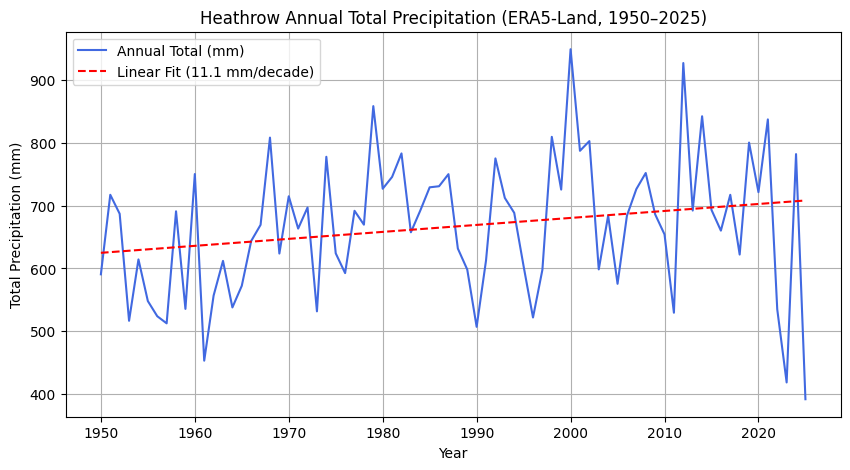


📈 Trend ≈ 11.09 mm per decade

Average annual total (1950–2025): 666.4 mm ± 110.8 mm


In [66]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/totprecip.nc'

# Open dataset (no need for chunks if it’s small enough)
ds = xr.open_dataset(file_path)
varname = 'tp'   # total precipitation variable name
print(ds)
# rename if needed
if 'valid_time' in ds.dims:
    ds = ds.rename({'valid_time': 'time'})

# 3. Convert from "m per day" to "m per month" and then "m per year"
# ===============================================================

# Each monthly value in ERA5-Land is the *average per day* for that month
# Multiply by number of days per month to get total precipitation per month
days_in_month = ds['time'].dt.days_in_month
monthly_total = ds[varname] * days_in_month

# Group by year → sum 12 months together to get yearly total per grid cell
yearly_totals = monthly_total.groupby('time.year').sum(dim='time')

print("\n✅ Yearly totals computed:")
print(yearly_totals)

# ===============================================================
# 4. Extract Heathrow location
# ===============================================================
heathrow_lat = 51.479
heathrow_lon = -0.452

# Select the nearest grid cell to Heathrow
heathrow_data = yearly_totals.sel(latitude=heathrow_lat,
                                  longitude=heathrow_lon,
                                  method='nearest')

# Convert to pandas Series and change units m → mm
heathrow_series = heathrow_data.to_series() * 1000
heathrow_series.index.name = "Year"

print("\n Heathrow annual total precipitation (mm):")
print(heathrow_series.head(10))
print(heathrow_series.tail(10))

# ===============================================================
# 5. Plot annual totals with linear trend
# ===============================================================

# Linear regression
x = np.arange(len(heathrow_series))
y = heathrow_series.values
coeffs = np.polyfit(x, y, 1)
fit = np.polyval(coeffs, x)
trend_per_decade = coeffs[0] * 10  # mm/decade

# Plot
plt.figure(figsize=(10, 5))
plt.plot(heathrow_series.index, y, label='Annual Total (mm)', color='royalblue')
plt.plot(heathrow_series.index, fit, '--', color='red', label=f'Linear Fit ({trend_per_decade:.1f} mm/decade)')
plt.title('Heathrow Annual Total Precipitation (ERA5-Land, 1950–2025)')
plt.xlabel('Year')
plt.ylabel('Total Precipitation (mm)')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n📈 Trend ≈ {trend_per_decade:.2f} mm per decade")

# ===============================================================
# 6. Optional: print mean and std for reference
# ===============================================================
mean_rain = heathrow_series.mean()
std_rain = heathrow_series.std()
print(f"\nAverage annual total (1950–2025): {mean_rain:.1f} mm ± {std_rain:.1f} mm")



--- Linear fit parameters ---
Slope = 1.216 ± 0.579 mm/year
Intercept = 835.1 ± 25.2 mm
Z-score (slope/sigma) = 2.10
Trend (1950–2025): 92.4 mm total change over 75 years


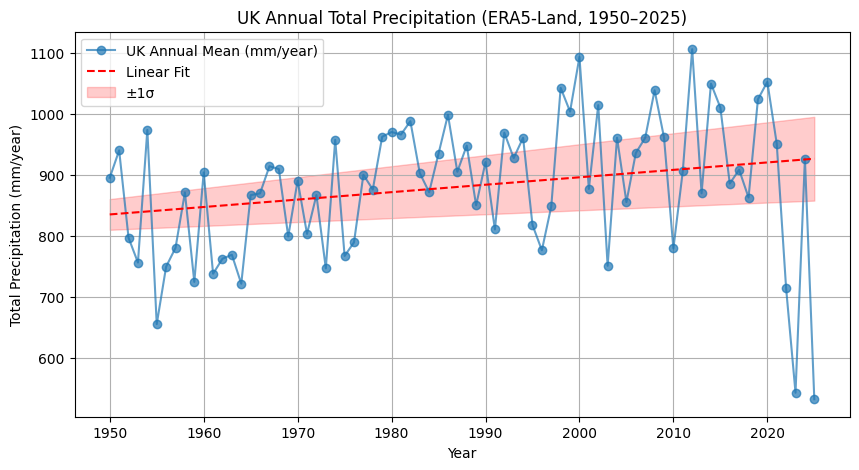


Mean annual precipitation (UK): 880.7 mm/year
Min: 532.6 mm, Max: 1105.6 mm


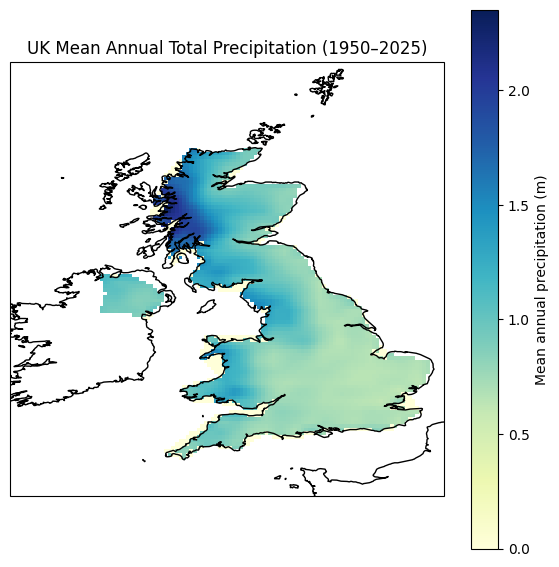

In [101]:
import xarray as xr
import regionmask
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/totprecip.nc'
ds = xr.open_dataset(file_path)
varname = 'tp'  # total precipitation

# Rename for regionmask
ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})

# -------------------------
# Compute monthly totals (m/month)
# -------------------------
days_in_month = ds['valid_time'].dt.days_in_month
monthly_total = ds[varname] * days_in_month  # m/month

# -------------------------
# Compute yearly totals (m/year)
# -------------------------
yearly_totals = monthly_total.groupby('valid_time.year').sum(dim='valid_time')

# -------------------------
# Mask UK grid cells
# -------------------------
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
uk_index = countries.names.index('United Kingdom')
uk_mask = countries.mask(yearly_totals) == uk_index  # True for UK cells

uk_data = yearly_totals.where(uk_mask)

# -------------------------
# Compute area-weighted UK annual mean (mm/year)
# -------------------------
lat_radians = np.deg2rad(uk_data['lat'])
weights = np.cos(lat_radians)
uk_weighted_mean = ((uk_data * weights).sum(dim=['lat', 'lon'], skipna=True) /
                    weights.where(~np.isnan(uk_data)).sum(dim=['lat', 'lon'], skipna=True))

uk_annual_mm = uk_weighted_mean * 1000  # convert m → mm

# -------------------------
# Linear fit
# -------------------------
years = uk_annual_mm['year'].values
y = uk_annual_mm.values
x = np.arange(len(y))

# Fit and retrieve covariance matrix
p, cov = np.polyfit(x, y, 1, cov=True)
slope, intercept = p
slope_err, intercept_err = np.sqrt(np.diag(cov))

# Compute z-score for slope significance
z_score = slope / slope_err

print("\n--- Linear fit parameters ---")
print(f"Slope = {slope:.3f} ± {slope_err:.3f} mm/year")
print(f"Intercept = {intercept:.1f} ± {intercept_err:.1f} mm")
print(f"Z-score (slope/sigma) = {z_score:.2f}")
print(f"Trend (1950–2025): {slope * len(y):.1f} mm total change over 75 years")

# --- Plot UK annual precipitation with linear trend with ±1σ uncertainty band ---
plt.figure(figsize=(10,5))
plt.plot(years, y, 'o-', label='UK Annual Mean (mm/year)', alpha=0.7)

# Linear fit and ±1σ envelope
y_fit = np.polyval(p, x)
y_fit_upper = np.polyval([slope + slope_err, intercept + intercept_err], x)
y_fit_lower = np.polyval([slope - slope_err, intercept - intercept_err], x)

plt.plot(years, y_fit, 'r--', label='Linear Fit')
plt.fill_between(years, y_fit_lower, y_fit_upper, color='r', alpha=0.2, label='±1σ')

plt.xlabel('Year')
plt.ylabel('Total Precipitation (mm/year)')
plt.title('UK Annual Total Precipitation (ERA5-Land, 1950–2025)')
plt.grid(True)
plt.legend()
plt.show()

# -------------------------
# Sanity check on mean value range
# -------------------------
print(f"\nMean annual precipitation (UK): {np.nanmean(y):.1f} mm/year")
print(f"Min: {np.nanmin(y):.1f} mm, Max: {np.nanmax(y):.1f} mm")

# -------------------------
# Plot UK spatial map (long-term mean)
# -------------------------
uk_mean_map = uk_data.mean(dim='year', skipna=True)

plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())
uk_mean_map.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='YlGnBu',
    cbar_kwargs={'label': 'Mean annual precipitation (m)'}
)
ax.coastlines()
plt.title("UK Mean Annual Total Precipitation (1950–2025)")
plt.show()



--- Linear fit (excluding 2022–2025) ---
Slope = 2.418 ± 0.482 mm/year
Intercept = 806.1 ± 19.8 mm
Z-score (slope/sigma) = 5.02
Trend (1950–2021): 174.1 mm total change over 72 years


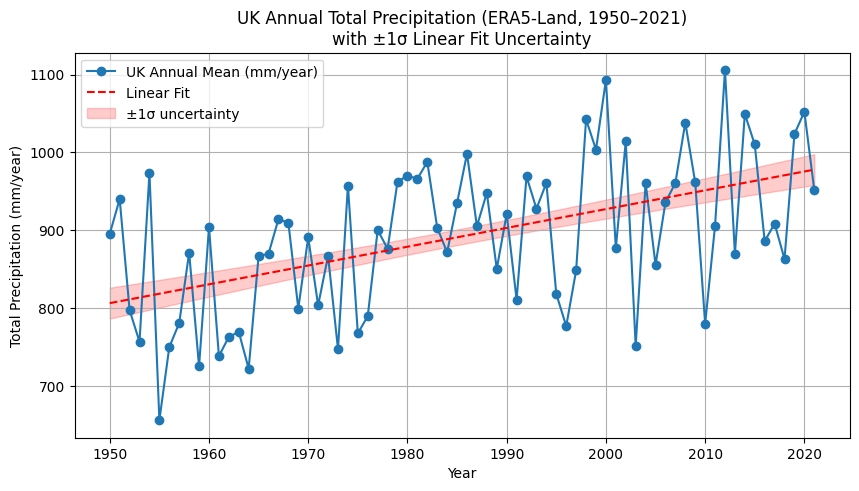

In [107]:
# Trim the last 4 years
y_trimmed = y[:-4]
x_trimmed = np.arange(len(y_trimmed))
years_trimmed = years[:-4]

# Linear fit with covariance for uncertainty
coeffs_trimmed, cov_trimmed = np.polyfit(x_trimmed, y_trimmed, 1, cov=True)
slope_trimmed, intercept_trimmed = coeffs_trimmed
errors_trimmed = np.sqrt(np.diag(cov_trimmed))
slope_err_trimmed, intercept_err_trimmed = errors_trimmed

# Z-score for slope significance
z_trimmed = slope_trimmed / slope_err_trimmed  

# Print results
print("\n--- Linear fit (excluding 2022–2025) ---")
print(f"Slope = {slope_trimmed:.3f} ± {slope_err_trimmed:.3f} mm/year")
print(f"Intercept = {intercept_trimmed:.1f} ± {intercept_err_trimmed:.1f} mm")
print(f"Z-score (slope/sigma) = {z_trimmed:.2f}")
print(f"Trend (1950–2021): {slope_trimmed * len(y_trimmed):.1f} mm total change over {len(y_trimmed)} years")

# Predicted line
y_fit = intercept_trimmed + slope_trimmed * x_trimmed

# --- Compute ±1σ confidence band ---
# Propagate covariance uncertainty for each x
y_std = np.sqrt(
    cov_trimmed[0,0]*x_trimmed**2 +   # var(slope)*x^2
    cov_trimmed[1,1] +                # var(intercept)
    2*x_trimmed*cov_trimmed[0,1]      # 2*cov(slope,intercept)*x
)

# -------------------------
# Plot trimmed annual precipitation and linear trend + 1σ band
# -------------------------
plt.figure(figsize=(10,5))
plt.plot(years_trimmed, y_trimmed, 'o-', label='UK Annual Mean (mm/year)')
plt.plot(years_trimmed, y_fit, 'r--', label='Linear Fit')
plt.fill_between(years_trimmed, y_fit - y_std, y_fit + y_std, color='r', alpha=0.2, label='±1σ uncertainty')

plt.xlabel('Year')
plt.ylabel('Total Precipitation (mm/year)')
plt.title('UK Annual Total Precipitation (ERA5-Land, 1950–2021)\nwith ±1σ Linear Fit Uncertainty')
plt.grid(True)
plt.legend()
plt.show()


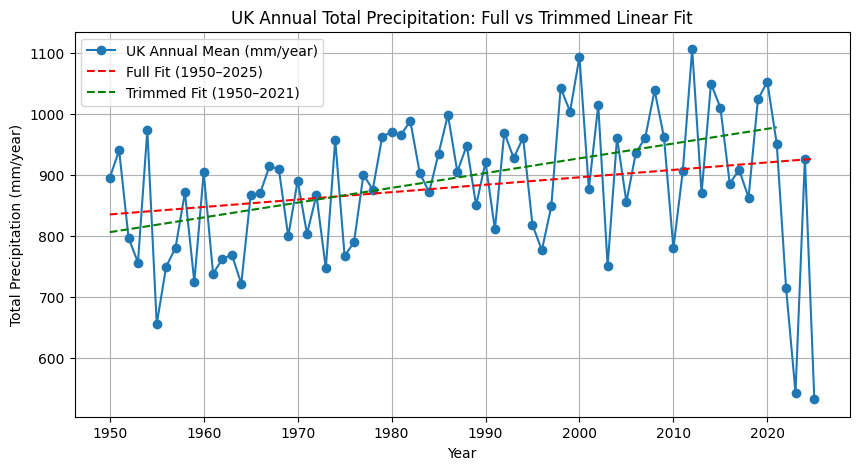

In [106]:
# Plot comparison
plt.figure(figsize=(10,5))
plt.plot(years, y, 'o-', label='UK Annual Mean (mm/year)')
plt.plot(years, intercept + slope * x, 'r--', label='Full Fit (1950–2025)')
plt.plot(years_trimmed, intercept_trimmed + slope_trimmed * x_trimmed, 'g--', label='Trimmed Fit (1950–2021)')
plt.xlabel('Year')
plt.ylabel('Total Precipitation (mm/year)')
plt.title('UK Annual Total Precipitation: Full vs Trimmed Linear Fit')
plt.grid(True)
plt.legend()
plt.show()

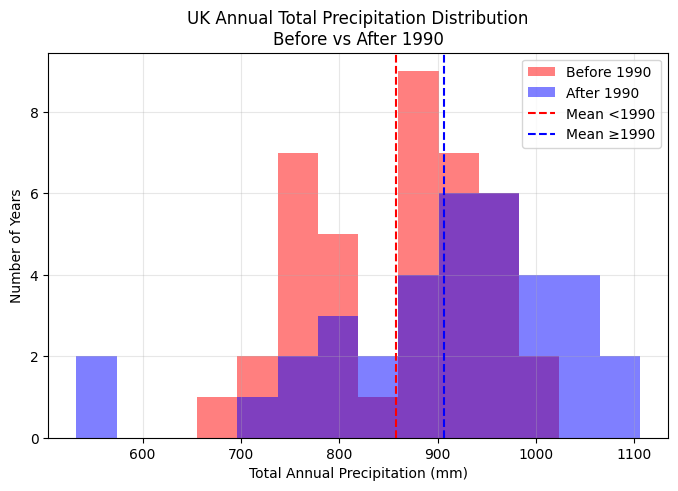

In [111]:
# histogram 

import matplotlib.pyplot as plt
import numpy as np

# --- Split the data ---
years = uk_annual_mm['year'].values
y = uk_annual_mm.values

# Mask pre- and post-1990
pre1990 = y[years < 1990]
post1990 = y[years >= 1990]

# --- Create the histogram ---
plt.figure(figsize=(8,5))
bins = np.linspace(np.nanmin(y), np.nanmax(y), 15)  # consistent bin edges for both groups

plt.hist(pre1990, bins=bins, color='red', alpha=0.5, label='Before 1990')
plt.hist(post1990, bins=bins, color='blue', alpha=0.5, label='After 1990')

# --- Labels and styling ---
plt.xlabel('Total Annual Precipitation (mm)')
plt.ylabel('Number of Years')
plt.axvline(np.nanmean(pre1990), color='red', linestyle='--', label='Mean <1990')
plt.axvline(np.nanmean(post1990), color='blue', linestyle='--', label='Mean ≥1990')
plt.title('UK Annual Total Precipitation Distribution\nBefore vs After 1990')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Found 37 station files.
Combined dataset shape: (38583, 8)

🌧️ Annual UK average precipitation (mm):
year
2022     866.2
2023    1075.4
2024    1006.5
2025     597.2
Name: rain, dtype: float64

📆 Mean rainfall by month (mm):
month
1      80.5
2      76.7
3      69.4
4      56.4
5      50.1
6      49.8
7      67.9
8      57.4
9      99.0
10    113.7
11    107.8
12    112.7
Name: rain, dtype: float64

📍 Mean rainfall by station (mm):
station
Eskdalemuir                                            157.6
Dunstaffnage                                           134.8
Tiree                                                  108.4
Ballypatrick Forest                                    106.9
Cardiff Bute Park                                      105.7
Lerwick                                                104.2
Stornoway                                              103.6
Camborne                                                91.4
Newton Rigg                                             86.1
Braemar

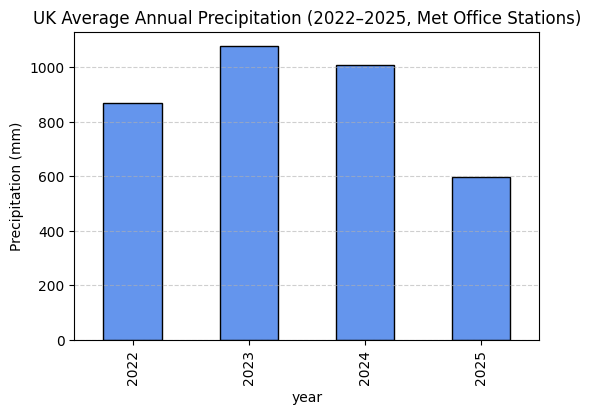

In [22]:
#Checks: 1 number for each year (averaged over locations and summed over months)

import glob
import re

# ------------------------------------------------------------
# 1️. Folder with Met Office.txt files
# ------------------------------------------------------------
folder = "/Users/ghosh/OneDrive/Documents/Year 4/Final project/MET_data/"  
files = sorted(glob.glob(folder + "*.txt"))
print(f"Found {len(files)} station files.")

all_data = []

# ------------------------------------------------------------
# 2. Loop through all station files
# ------------------------------------------------------------
for file in files:
    with open(file, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()

    station_name = lines[0].strip()

    # Find start of numeric data
    data_start = None
    for i, line in enumerate(lines):
        if re.match(r"\s*\d{4}\s", line):
            data_start = i
            break
    if data_start is None:
        print(f"No data found in {station_name}")
        continue

    # Read numeric block — handle flexible spacing and extra words
    df = pd.read_csv(
        file,
        sep=r'\s+',
        skiprows=data_start,
        names=["year", "month", "tmax", "tmin", "af", "rain", "sun", "extra"],
        na_values=["---", " ", ""],
        engine="python",
        on_bad_lines="skip"
    )

    # Drop extra column if created
    if "extra" in df.columns:
        df = df.drop(columns=["extra"])

    # --- Clean “rain” column ---
    df["rain"] = df["rain"].astype(str)
    # Remove asterisks (*) and text like 'Provisional'
    df["rain"] = df["rain"].str.replace("*", "", regex=False)
    df["rain"] = df["rain"].str.replace("Provisional", "", regex=False)
    df["rain"] = df["rain"].str.strip()
    df["rain"] = pd.to_numeric(df["rain"], errors="coerce")

    # --- Keep valid rows ---
    df = df.dropna(subset=["year", "rain"])
    df["station"] = station_name

    all_data.append(df)

# ------------------------------------------------------------
# 3️. Combine all stations
# ------------------------------------------------------------
data = pd.concat(all_data, ignore_index=True)
print(f"Combined dataset shape: {data.shape}")

# ------------------------------------------------------------
# 4️. Filter years of interest (2022–2025)
# ------------------------------------------------------------
years_of_interest = [2022, 2023, 2024, 2025]
data = data[data["year"].isin(years_of_interest)]

# ------------------------------------------------------------
# 5️. Compute: one number per year (avg over stations, sum over months)
# ------------------------------------------------------------
annual_by_station = (
    data.groupby(["station", "year"])["rain"].sum(min_count=1).reset_index() # groups together all months for each station in each year, then sums the rainfall across all months for that station in that year
)

annual_mean_uk = annual_by_station.groupby("year")["rain"].mean() # takes the mean of all station totals to get the average annual rainfall across all UK stations

# ------------------------------------------------------------
# 6️. Checks — which year, month, and stations dominate
# ------------------------------------------------------------
month_mean = data.groupby("month")["rain"].mean() # Groups all data by month - mean rainfall per month averaged over all stations and years
station_mean = data.groupby("station")["rain"].mean() # Groups all data by station - 

# ------------------------------------------------------------
# 7️. Print and plot results
# ------------------------------------------------------------
print("\n Annual UK average precipitation (mm):")
print(annual_mean_uk.round(1))

print("\n Mean rainfall by month (mm):")
print(month_mean.round(1))

print("\n Mean rainfall by station (mm):")
print(station_mean.round(1).sort_values(ascending=False).head(37))

# Plot
plt.figure(figsize=(6,4))
annual_mean_uk.plot(kind="bar", color="cornflowerblue", edgecolor="k")
plt.title("UK Average Annual Precipitation (2022–2025, Met Office Stations)")
plt.ylabel("Precipitation (mm)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()



📅 Monthly average rainfall by year (mm):
month    1      2      3     4     5     6      7     8      9      10     11  \
year                                                                            
2022   44.3  111.3   42.9  38.2  59.0  51.0   34.5  39.9   89.1  117.0  144.0   
2023   97.3   29.5  110.3  63.6  35.7  44.6  113.3  76.3   97.8  155.2  105.3   
2024   93.9  110.9   95.5  86.9  71.0  40.0   71.0  70.3  109.1   87.1   74.1   
2025   86.4   55.1   28.9  36.7  34.8  63.6   52.8  43.2  100.1   95.6    NaN   

month     12  
year          
2022    95.0  
2023   146.4  
2024    96.8  
2025     NaN  


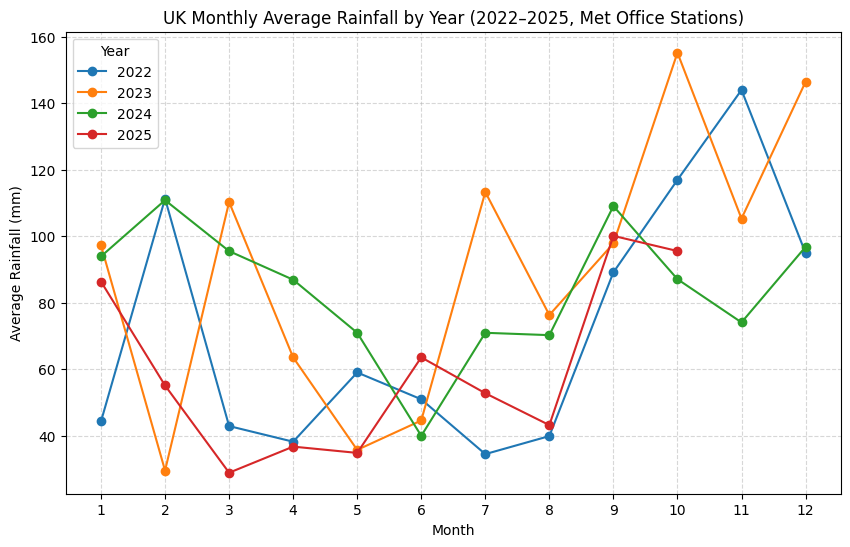

In [29]:
# ------------------------------------------------------------
# Monthly averages per year (12 numbers per year)
# ------------------------------------------------------------
monthly_by_year = data.groupby(["year", "month"])["rain"].mean().unstack()
print("\n📅 Monthly average rainfall by year (mm):")
print(monthly_by_year.round(1))

# Plot: one plot per year
plt.figure(figsize=(10,6))
for year in monthly_by_year.index:
    plt.plot(
        monthly_by_year.columns, 
        monthly_by_year.loc[year], 
        marker='o', 
        label=str(year)
    )

plt.title("UK Monthly Average Rainfall by Year (2022–2025, Met Office Stations)")
plt.xlabel("Month")
plt.ylabel("Average Rainfall (mm)")
plt.xticks(range(1,13))  # Ensure months 1-12
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Year")
plt.show()
